Importer les Bibliothèques Nécessaires

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder ,StandardScaler , LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import os
import math

Lire le jeu de données et supprimer les colonnes Id, Alley et Fence, car Id n'est pas nécessaire et Alley ainsi que Fence contiennent beaucoup de valeurs manquantes et ne sont pas utiles dans le dataset, car elles n'influencent pas beaucoup le prix


In [21]:
train = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/train.csv")
test = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

train.columns = train.columns.astype(str).str.strip()

test.columns = test.columns.astype(str).str.strip()
y_SalePrice = train['SalePrice']
train.drop("Id", axis = 1, inplace = True)
train.drop("SalePrice", axis = 1, inplace = True)

test.drop("Id", axis = 1, inplace = True)

In [22]:
print("Taille de train "  , train.shape)
print("Taille de test" , test.shape)

Taille de train  (1460, 79)
Taille de test (1459, 79)


In [23]:
print("\nNombre de features de chaque type :")
print(train.dtypes.value_counts())


Nombre de features de chaque type :
object    46
int64     33
Name: count, dtype: int64


détecter les types généraux

In [24]:
categorical_features = train.select_dtypes(include=['object']).columns
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
numerical_features_test = test.select_dtypes(include=['int64', 'float64']).columns

print("Catégorielles :", categorical_features)
print("Numériques :", numerical_features)



Catégorielles : Index(['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')
Numériques : Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath

Vérification des types de données et conversion

In [25]:
# Vérification des types de données et conversion
for column in ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']:
    train[column] = pd.to_numeric(train[column], errors='coerce')
    test[column] = pd.to_numeric(test[column], errors='coerce')

# Remplissage des valeurs manquantes
train['LotFrontage'].fillna(train['LotFrontage'].median(), inplace=True)
train['GarageYrBlt'].fillna(0, inplace=True)
train['MasVnrArea'].fillna(0, inplace=True)

test['LotFrontage'].fillna(test['LotFrontage'].median(), inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)


/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_82463/958585337.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['LotFrontage'].fillna(train['LotFrontage'].median(), inplace=True)
/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_82463/958585337.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

les outliers 

In [26]:
def cap_outliers_iqr(df):
    for column in df.select_dtypes(include=['int64', 'float64']):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df[column] = np.clip(df[column], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    return df

train = cap_outliers_iqr(train)
test = cap_outliers_iqr(test)


Création de nouvelles fonctionnalités

In [27]:

train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

train['TotalBathrooms'] = train['FullBath'] + (0.5 * train['HalfBath']) + train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath'])
test['TotalBathrooms'] = test['FullBath'] + (0.5 * test['HalfBath']) + test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath'])


Encoding 

In [28]:


train_ordinal = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']

train_nominal = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating",
                    "CentralAir", 'Electrical',"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

test_ordinal = train_ordinal
test_nominal = train_nominal

ordinal_mappings = {
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["NA", "No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    "FireplaceQu": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageFinish": ["NA", "Unf", "RFn", "Fin"],
    "GarageQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "PavedDrive": ["N", "P", "Y"],
    "PoolQC": ["NA", "Fa", "TA", "Gd", "Ex"],
    "Fence": ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"]
}

# -------------------
# Encodage Ordinal (train & test)
# -------------------

# Supprimer les espaces et remplir les valeurs manquantes avec "NA" (ou autre valeur neutre)
for col in train_ordinal:
    train[col] = train[col].astype(str).str.strip().fillna("NA")
    test[col] = test[col].astype(str).str.strip().fillna("NA")

# Initialiser et appliquer OrdinalEncoder avec gestion des valeurs inconnues
ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in train_ordinal], 
                                 handle_unknown="use_encoded_value", 
                                 unknown_value=-1)

train[train_ordinal] = ordinal_encoder.fit_transform(train[train_ordinal])
test[test_ordinal] = ordinal_encoder.transform(test[test_ordinal])  # Pas de fit sur test !

train = pd.get_dummies(train, columns=train_nominal, dtype=int)
test = pd.get_dummies(test, columns=train_nominal, dtype=int)


missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0 

# S'assurer que l'ordre des colonnes est le même
test = test[train.columns]




/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_82463/368611234.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[col] = 0
/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_82463/368611234.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[col] = 0
/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_82463/368611234.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

information mutuelle

In [29]:
def select_features(train, test, y, threshold=0.1):
    # Information mutuelle pour les features numériques
    numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
    mutual_infoN = mutual_info_regression(train[numerical_features].fillna(0), y, random_state=1)
    mutual_infoN = pd.Series(mutual_infoN, index=numerical_features)
    
    # Suppression des features peu importantes
    low_mi_features = mutual_infoN[mutual_infoN < mutual_infoN.quantile(threshold)].index
    train.drop(columns=low_mi_features, inplace=True)
    test.drop(columns=low_mi_features, inplace=True)
    
    return train, test

train, test = select_features(train, test, y_SalePrice)


Pourcentage de valeurs manquantes

In [30]:
missing_percentage = (train.isnull().sum() / len(train)) * 100
missing_data = missing_percentage[missing_percentage > 0]

print(missing_data)



Series([], dtype: float64)


Standardisation (scaling) avec pipeline

In [31]:
# Pipeline pour la standardisation
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

train[numeric_features] = pipeline.fit_transform(train[numeric_features])
test[numeric_features] = pipeline.transform(test[numeric_features])

PCA

In [32]:


def apply_pca(train, test):
    # Sélection des colonnes numériques
    numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
    
    # Imputation des valeurs manquantes
    imputer = SimpleImputer(strategy='mean')  # Vous pouvez utiliser 'median' ou 'most_frequent' si nécessaire
    train[numerical_features] = imputer.fit_transform(train[numerical_features])
    test[numerical_features] = imputer.transform(test[numerical_features])
    
    # Application de PCA
    pca = PCA(n_components=0.95)
    train_pca = pca.fit_transform(train[numerical_features])
    test_pca = pca.transform(test[numerical_features])
    
    # Conversion en DataFrame
    pca_columns = [f"PCA_{i}" for i in range(train_pca.shape[1])]
    train_pca_df = pd.DataFrame(train_pca, columns=pca_columns)
    test_pca_df = pd.DataFrame(test_pca, columns=pca_columns)
    
    # Mise à jour des datasets
    train = train.drop(columns=numerical_features).reset_index(drop=True)
    test = test.drop(columns=numerical_features).reset_index(drop=True)
    
    train = pd.concat([train, train_pca_df], axis=1)
    test = pd.concat([test, test_pca_df], axis=1)
    
    return train, test

# Appliquer PCA
train, test = apply_pca(train, test)

La coorelation

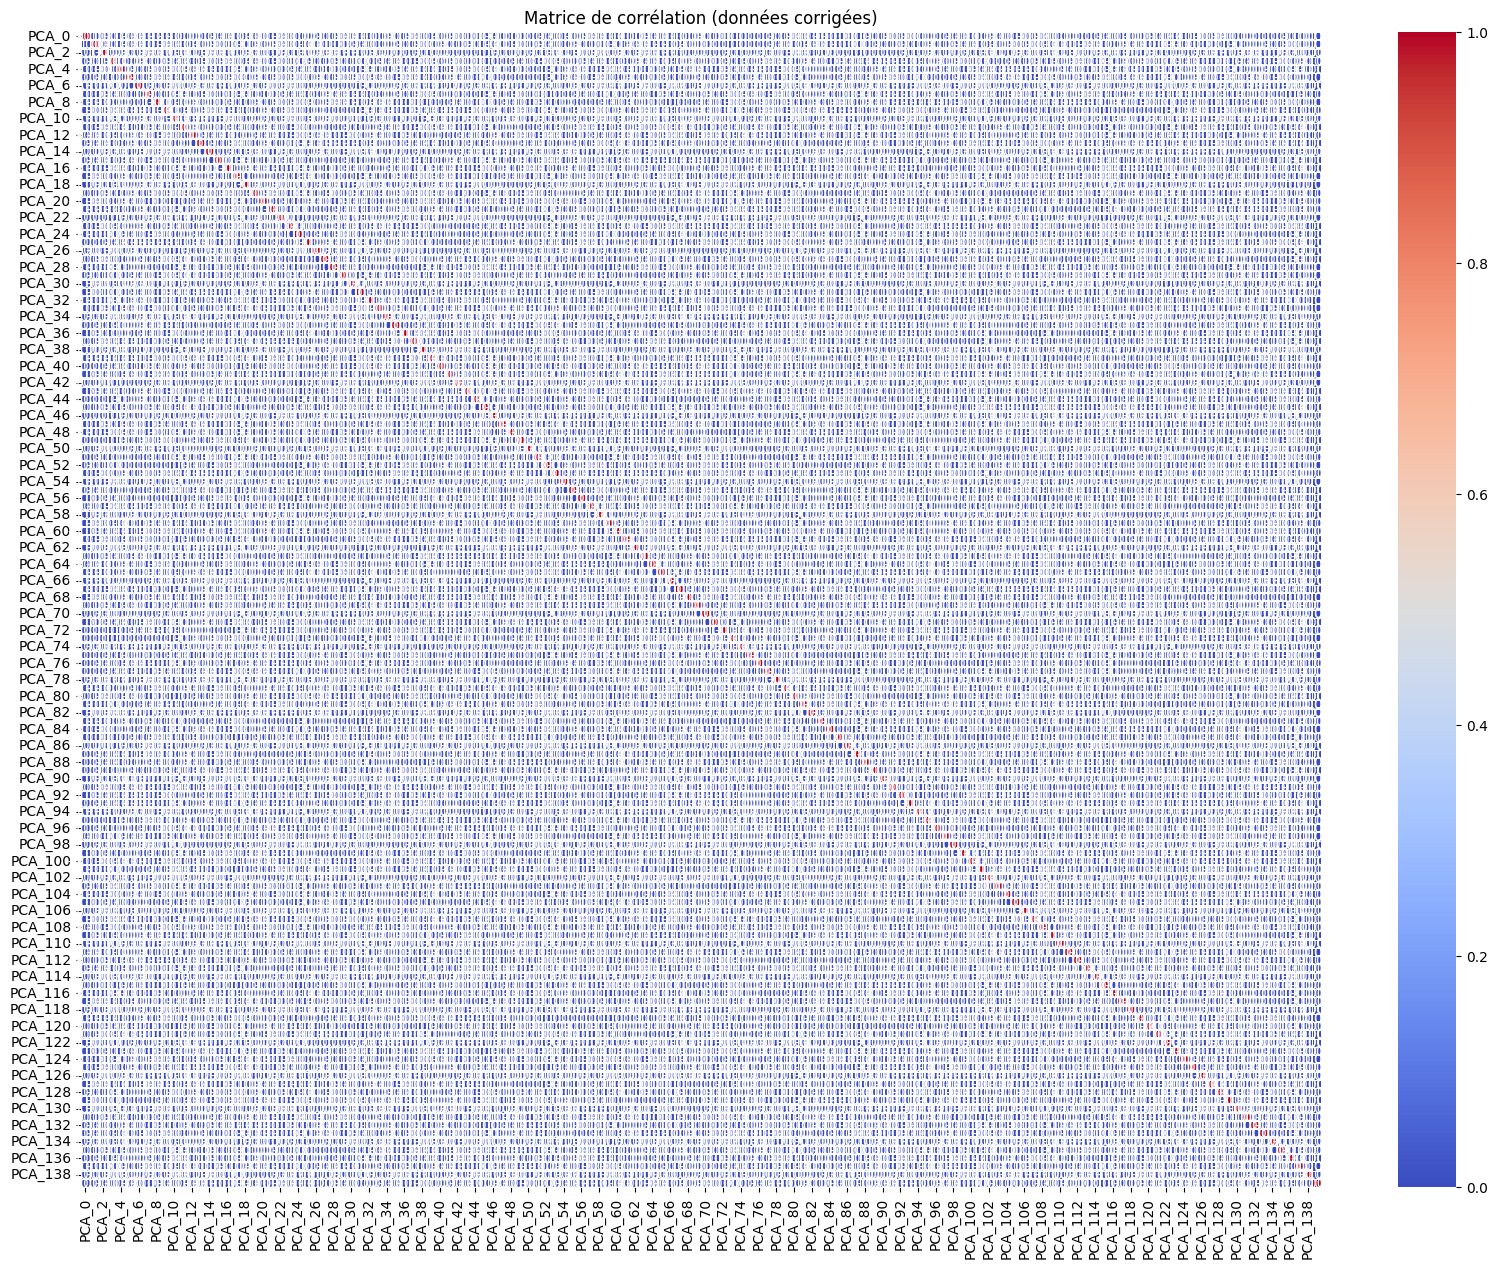

In [33]:
numeric_data = train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation (données corrigées)')
plt.show()

Extraction des couples de variables ayant une corrélation supérieure à 0.8

In [34]:
corr_threshold = 0.8
corr_pairs = {}

for col in correlation_matrix.columns:
    corr_pairs[col] = []
    corr_values = correlation_matrix[abs(correlation_matrix[col]) > corr_threshold][col].index.tolist()
    for pair in corr_values:
        if pair != col:
            corr_pairs[col].append(pair)

# Affichage des couples de variables ayant une corrélation supérieure à 0.8
print("Couples de variables ayant une corrélation supérieure à 0.8 :\n")
for col, pairs in corr_pairs.items():
    if len(pairs) > 0:
        for pair in pairs:
            print(col, "-", pair)

Couples de variables ayant une corrélation supérieure à 0.8 :



  dropping features

In [35]:
# Liste des colonnes à supprimer
columns_to_drop = ["GarageArea", "1stFlrSF", "TotRmsAbvGrd"]

# Vérifier si les colonnes existent avant de les supprimer
train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
test = test.drop(columns=[col for col in columns_to_drop if col in test.columns])

print("✅ Colonnes supprimées avec succès !")


✅ Colonnes supprimées avec succès !


In [36]:
train.fillna("NA", inplace=True)
test.fillna("NA", inplace=True)

 Encoding des Features Ordinales et nominals

In [37]:
train = pd.concat([train, y_SalePrice], axis=1)

final Data

In [38]:
print(train.shape,test.shape)
train.to_csv('final_data.csv', index=False)

test.to_csv('final_test_data.csv', index=False)


(1460, 141) (1459, 140)
